In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
zip_path = "/content/drive/MyDrive/archive.zip"

In [3]:
!unzip -q "/content/drive/MyDrive/archive.zip" #unzips without printing so this doesn't print a billion things

In [4]:
import os, shutil, random

SRC = "/content/ai_art_classification/train"
DST = "/content/sample_train"
os.makedirs(DST, exist_ok=True)

classes = ["AI_GENERATED", "NON_AI_GENERATED"]
images_per_class = 300  # 600 images total

for cls in classes:
    src_class_dir = os.path.join(SRC, cls)
    dst_class_dir = os.path.join(DST, cls)
    os.makedirs(dst_class_dir, exist_ok=True)

    files = [f for f in os.listdir(src_class_dir) if f.lower().endswith(('jpg','jpeg','png'))]
    pick = random.sample(files, min(images_per_class, len(files)))

    for f in pick:
        shutil.copy2(os.path.join(src_class_dir, f),
                     os.path.join(dst_class_dir, f))

print("sample dataset created:", DST)


Sample dataset created: /content/sample_train


In [5]:
SOURCE = "/content/sample_train"
DEST = "/content/split_dataset"
train_ratio = 0.8

classes = ["AI_GENERATED", "NON_AI_GENERATED"]

for split in ["train", "val"]:
    for cls in classes:
        os.makedirs(os.path.join(DEST, split, cls), exist_ok=True)

for cls in classes:
    src = os.path.join(SOURCE, cls)
    files = [f for f in os.listdir(src) if f.lower().endswith(('jpg','jpeg','png'))]

    random.shuffle(files)

    split_idx = int(len(files) * train_ratio)
    train_files = files[:split_idx]
    val_files = files[split_idx:]

    for f in train_files:
        shutil.copy(os.path.join(src, f),
                    os.path.join(DEST, "train", cls, f))
    for f in val_files:
        shutil.copy(os.path.join(src, f),
                    os.path.join(DEST, "val", cls, f))

print("dataset split here:", DEST)


Dataset split at: /content/split_dataset


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DATA_DIR = "/content/split_dataset"
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_gen = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

print("good to go.")


Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Generators ready.


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
#using MobileNetV2 as it's better for smaller datasets
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(base_model.input, output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)
#train

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5505 - loss: 0.7641 - val_accuracy: 0.7000 - val_loss: 0.5362
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 890ms/step - accuracy: 0.6952 - loss: 0.5732 - val_accuracy: 0.7833 - val_loss: 0.4534
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 917ms/step - accuracy: 0.7856 - loss: 0.4542 - val_accuracy: 0.8083 - val_loss: 0.4248
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 895ms/step - accuracy: 0.7755 - loss: 0.4645 - val_accuracy: 0.8250 - val_loss: 0.3937
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 926ms/step - accuracy: 0.8159 - loss: 0.3743 - val_accuracy: 0.8167 - val_loss: 0.3839
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 927ms/step - accuracy: 0.8419 - loss: 0.3609 - val_accuracy: 0.8333 - val_loss: 0.3768
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 928ms/step - accuracy: 0.8161 - loss: 0.3726 - val_accuracy: 0.8417 - val_loss: 0.3747
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 922ms/step - accuracy: 0.8687 - loss: 0.3265 - val_accurac

In [9]:
#unfreezing last 100 layers for fine tunin
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
#here we get our validation set
history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7672 - loss: 0.4918 - val_accuracy: 0.8417 - val_loss: 0.3604
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7858 - loss: 0.4479 - val_accuracy: 0.8417 - val_loss: 0.3551
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.7722 - loss: 0.5270 - val_accuracy: 0.8417 - val_loss: 0.3505
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8025 - loss: 0.4173 - val_accuracy: 0.8500 - val_loss: 0.3482
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8033 - loss: 0.4072 - val_accuracy: 0.8417 - val_loss: 0.3446
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8447 - loss: 0.3430 - val_accuracy: 0.8417 - val_loss: 0.3416
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8847 - loss: 0.3153 - val_accuracy: 0.8417 - val_loss: 0.3387
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8922 - loss: 0.3070 - val_accuracy: 0.8417 - val_loss:

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

val_gen.reset()

preds = model.predict(val_gen)
pred_labels = (preds > 0.5).astype(int)
true_labels = val_gen.classes

print("Classification Report:")
print(classification_report(true_labels, pred_labels))

cm = confusion_matrix(true_labels, pred_labels)
print("Confusion matrix:\n", cm)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 932ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        60
           1       0.86      0.85      0.86        60

    accuracy                           0.86       120
   macro avg       0.86      0.86      0.86       120
weighted avg       0.86      0.86      0.86       120

Confusion matrix:
 [[52  8]
 [ 9 51]]


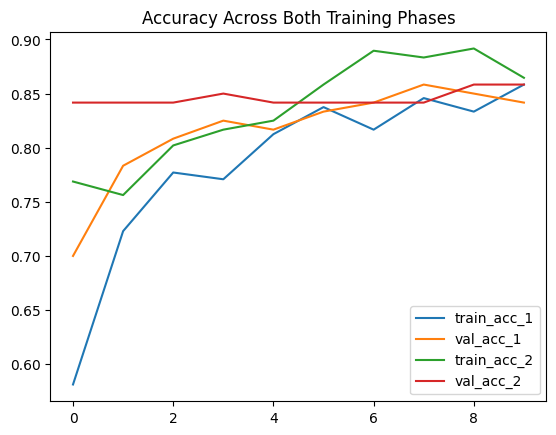

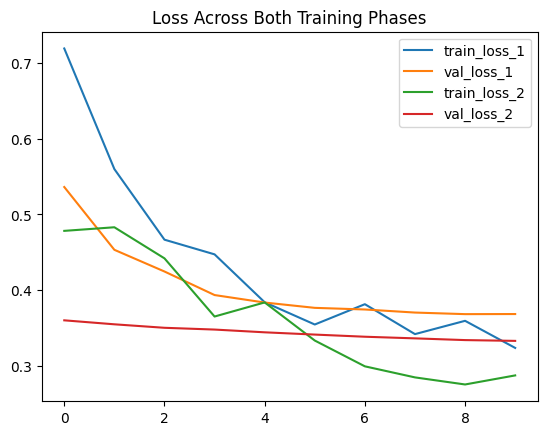

In [11]:
# accuracy
plt.plot(history1.history["accuracy"], label="train_acc_1")
plt.plot(history1.history["val_accuracy"], label="val_acc_1")
plt.plot(history2.history["accuracy"], label="train_acc_2")
plt.plot(history2.history["val_accuracy"], label="val_acc_2")
plt.legend()
plt.title("Accuracy Across Both Training Phases")
plt.show()

#loss
plt.plot(history1.history["loss"], label="train_loss_1")
plt.plot(history1.history["val_loss"], label="val_loss_1")
plt.plot(history2.history["loss"], label="train_loss_2")
plt.plot(history2.history["val_loss"], label="val_loss_2")
plt.legend()
plt.title("Loss Across Both Training Phases")
plt.show()
